## __Census Income dataset: ML analysis__

https://www.kaggle.com/datasets/tawfikelmetwally/census-income-dataset/data

### __Dataset Description__

This intermediate level data set was extracted from the census bureau database. There are 48842 instances of data set, mix of continuous and discrete (train=32561, test=16281). The data set has 15 attribute which include age, sex, education level and other relevant details of a person.The Following description gives more details on this data set:

- age: the age of an individual.
- workclass: The type of work or employment of an individual. It can have the following categories:
    - Private: Working in the private sector.
    - Self-emp-not-inc: Self-employed individuals who are not incorporated.
    - Self-emp-inc: Self-employed individuals who are incorporated.
    - Federal-gov: Working for the federal government.
    - Local-gov: Working for the local government.
    - State-gov: Working for the state government.
    - Without-pay: Not working and without pay.
    - Never-worked: Never worked before.
- Final Weight: The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls.
These are:
    - A single cell estimate of the population 16+ for each state.
    - Controls for Hispanic Origin by age and sex.
    - Controls by Race, age and sex.
- education: The highest level of education completed.
- education-num: The number of years of education completed.
- marital-status: The marital status.
- occupation: Type of work performed by an individual.
- relationship: The relationship status.
- race: The race of an individual.
- sex: The gender of an individual.
- capital-gain: The amount of capital gain (financial profit).
- capital-loss: The amount of capital loss an individual has incurred.
- hours-per-week: The number of hours works per week.
- native-country: The country of origin or the native country.
- income: The income level of an individual and serves as the target variable. It indicates whether the income is greater than `$50,000` or less than or equal to `$50,000`, denoted as (>50K, <=50K).



#### __Fetching data from Kaggle__

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle"
os.makedirs("/content/kaggle", exist_ok=True)
!mv kaggle.json /content/kaggle/
!chmod 600 /content/kaggle/kaggle.json
!kaggle datasets download -d tawfikelmetwally/census-income-dataset
!unzip census-income-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/tawfikelmetwally/census-income-dataset
License(s): unknown
  0% 0.00/691k [00:00<?, ?B/s]
100% 691k/691k [00:00<00:00, 965MB/s]
Archive:  census-income-dataset.zip
  inflating: adult.csv               
  inflating: adult.test.csv          


#### __Import the necessary libraries__

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### __Loading the dataset__

In [74]:
train_data = pd.read_csv('adult.csv')
test_data = pd.read_csv('adult.test.csv')

train_data.shape, test_data.shape

((32561, 15), (16280, 15))

In [75]:
train_data.head()

,Age,Workclass,Final Weight,Education,EducationNum,Marital Status,Occupation,Relationship,Race,Gender,Capital Gain,capital loss,Hours per Week,Native Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [76]:
test_data.head()

,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0.1,40,United-States,<=50K.
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
3,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.


##### __Observation:__

- Here, test data has incorrect column names, hence replacing `test_data` columns with the `train_data` columns.

In [78]:
train_data_cols = train_data.columns
test_data.columns = train_data_cols

In [80]:
test_data.head(2)

,Age,Workclass,Final Weight,Education,EducationNum,Marital Status,Occupation,Relationship,Race,Gender,Capital Gain,capital loss,Hours per Week,Native Country,Income
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.


#### __Inspecting the data and pre-processing the train dataset and data cleaning__

In [81]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   Final Weight    32561 non-null  int64 
 3   Education       32561 non-null  object
 4   EducationNum    32561 non-null  int64 
 5   Marital Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Gender          32561 non-null  object
 10  Capital Gain    32561 non-null  int64 
 11  capital loss    32561 non-null  int64 
 12  Hours per Week  32561 non-null  int64 
 13  Native Country  32561 non-null  object
 14  Income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [82]:
train_data.describe()

,Age,Final Weight,EducationNum,Capital Gain,capital loss,Hours per Week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [83]:
missing_values = train_data.isna().sum()
missing_values

,0
Age,0
Workclass,0
Final Weight,0
Education,0
EducationNum,0
Marital Status,0
Occupation,0
Relationship,0
Race,0
Gender,0


In [85]:
train_data['Income'].value_counts()

,count
Income,
<=50K,24720
>50K,7841


##### __Observation:__

- Here, missing or unknown values are indicated by `?` in the dataset, so we will need to clean the dataset.
- `Workclass`, `Occupation` and `Native Country` have `?` in their values.

In [86]:
train_data['Workclass'].value_counts()

,count
Workclass,
Private,22696
Self-emp-not-inc,2541
Local-gov,2093
?,1836
State-gov,1298
Self-emp-inc,1116
Federal-gov,960
Without-pay,14
Never-worked,7


In [87]:
train_data['Occupation'].value_counts()

,count
Occupation,
Prof-specialty,4140
Craft-repair,4099
Exec-managerial,4066
Adm-clerical,3770
Sales,3650
Other-service,3295
Machine-op-inspct,2002
?,1843
Transport-moving,1597


In [88]:
train_data['Native Country'].value_counts()

,count
Native Country,
United-States,29170
Mexico,643
?,583
Philippines,198
Germany,137
Canada,121
Puerto-Rico,114
El-Salvador,106
India,100


In [89]:
cols_with_unknowns = ['Workclass', 'Occupation', 'Native Country']
cleaned_train_data = train_data.copy()

for col in cols_with_unknowns:
  cleaned_train_data = cleaned_train_data[cleaned_train_data[col].str.contains('\?') == False]
  print(col, cleaned_train_data.shape)

Workclass (30725, 15)
Occupation (30718, 15)
Native Country (30162, 15)


In [90]:
cleaned_train_data = cleaned_train_data.reset_index(drop=True)

In [91]:
duplicate_values = cleaned_train_data.duplicated().sum()
duplicate_values

np.int64(23)

#### __Plot a correlation heatmap to understand the relationship between features__

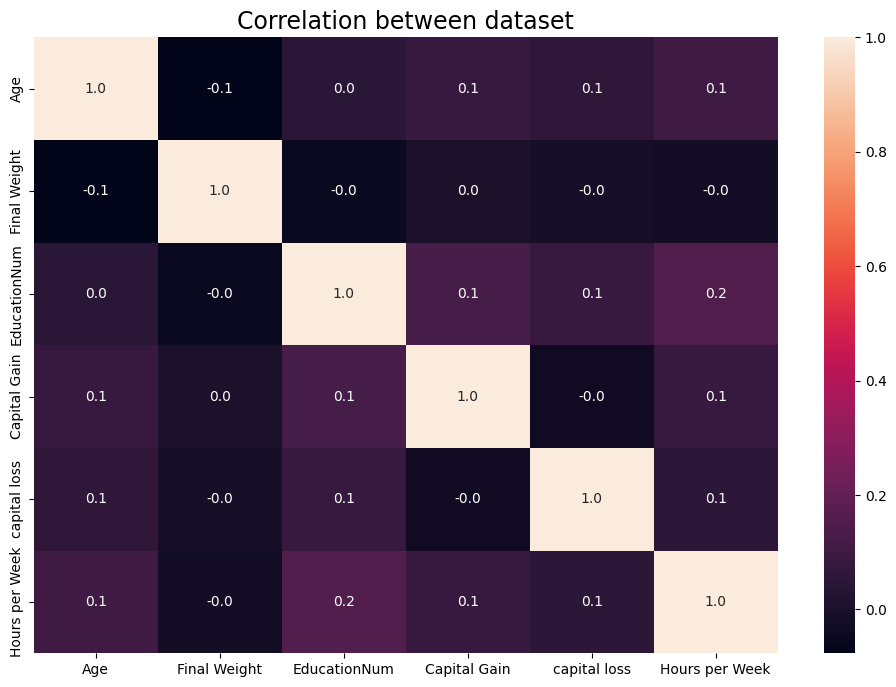

In [94]:
# Correlation heatmap
plt.figure(figsize=(12,8))

c = cleaned_train_data.corr(numeric_only=True)
sns.heatmap(c, annot=True, fmt=".1f")
plt.title("Correlation between dataset", fontsize=17, c="k")

plt.show()

In [95]:
# Here, `Education` column has correlation with `EducationNum` column as `EducationNum` shows no. of years of eduation
# So, we can drop `Education` column
cleaned_train_data.drop(columns=['Education'], inplace=True)

#### __Convert Categorical variables for the training data__

In [96]:
# Label encoder helps preserve the values of the original targets
label_encoder = LabelEncoder()
cleaned_train_data['Native Country'] = label_encoder.fit_transform(cleaned_train_data['Native Country'])

ohe_cols = ['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Gender', 'Income']
cleaned_train_data = pd.get_dummies(cleaned_train_data, columns=ohe_cols, drop_first=False, dtype=np.int8)

In [98]:
cleaned_train_data.head()

,Age,Final Weight,EducationNum,Capital Gain,capital loss,Hours per Week,Native Country,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Marital Status_ Divorced,Marital Status_ Married-AF-spouse,Marital Status_ Married-civ-spouse,Marital Status_ Married-spouse-absent,Marital Status_ Never-married,Marital Status_ Separated,Marital Status_ Widowed,Occupation_ Adm-clerical,Occupation_ Armed-Forces,Occupation_ Craft-repair,Occupation_ Exec-managerial,Occupation_ Farming-fishing,Occupation_ Handlers-cleaners,Occupation_ Machine-op-inspct,Occupation_ Other-service,Occupation_ Priv-house-serv,Occupation_ Prof-specialty,Occupation_ Protective-serv,Occupation_ Sales,Occupation_ Tech-support,Occupation_ Transport-moving,Relationship_ Husband,Relationship_ Not-in-family,Relationship_ Other-relative,Relationship_ Own-child,Relationship_ Unmarried,Relationship_ Wife,Race_ Amer-Indian-Eskimo,Race_ Asian-Pac-Islander,Race_ Black,Race_ Other,Race_ White,Gender_ Female,Gender_ Male,Income_ <=50K,Income_ >50K
0,39,77516,13,2174,0,40,38,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0
1,50,83311,13,0,0,13,38,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0
2,38,215646,9,0,0,40,38,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0
3,53,234721,7,0,0,40,38,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0
4,28,338409,13,0,0,40,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0


##### __Observation:__

- Here, `Income` is the outcome variable, i.e. value that we want to predict, but there are 2 income colums due to OHE, `Income_ <=50K` and `Income_ >50K`, so for the purposes of classification, we will remove the first column `Income_ <=50K`.

In [65]:
cleaned_train_data.drop(columns=['Income_ <=50K'], inplace=True)

In [68]:
X_train = cleaned_train_data.drop(columns=['Income_ >50K'])
y_train = cleaned_train_data['Income_ >50K']

In [100]:
X_train.shape, y_train.shape

((30162, 64), (30162,))

#### __Pre-processing the test dataset__



In [99]:
test_data.head()

,Age,Workclass,Final Weight,Education,EducationNum,Marital Status,Occupation,Relationship,Race,Gender,Capital Gain,capital loss,Hours per Week,Native Country,Income
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
3,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.
